In [9]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime

# Import from the trajDTW package instead of individual modules
from trajDTW import (
    anndata_to_3d_matrix, 
    calculate_trajectory_conservation,
    TrajectoryFitter,
    get_most_conserved_samples,
    fit_with_conserved_samples
)

# Set output directory
output_dir = Path("/home/gilberthan/Desktop/disk2/202409_tooth/process/trajectory/20250414_epi_run/")
output_dir.mkdir(parents=True, exist_ok=True)

print("\n=== Trajectory Conservation Analysis Pipeline ===\n")
print(f"Results will be saved to: {output_dir}")

# ================ 1. BUILD 3D MATRIX ================
print("\n1. Building 3D Matrix from AnnData")
print("-" * 50)

# Load AnnData
print("Loading AnnData...")
adata = sc.read_h5ad("../../../processed_data/toy_data/20250412_example_trajconserve.h5ad")
print(f"AnnData shape: {adata.shape}")


=== Trajectory Conservation Analysis Pipeline ===

Results will be saved to: /home/gilberthan/Desktop/disk2/202409_tooth/process/trajectory/20250414_epi_run

1. Building 3D Matrix from AnnData
--------------------------------------------------
Loading AnnData...
AnnData shape: (8000, 100)


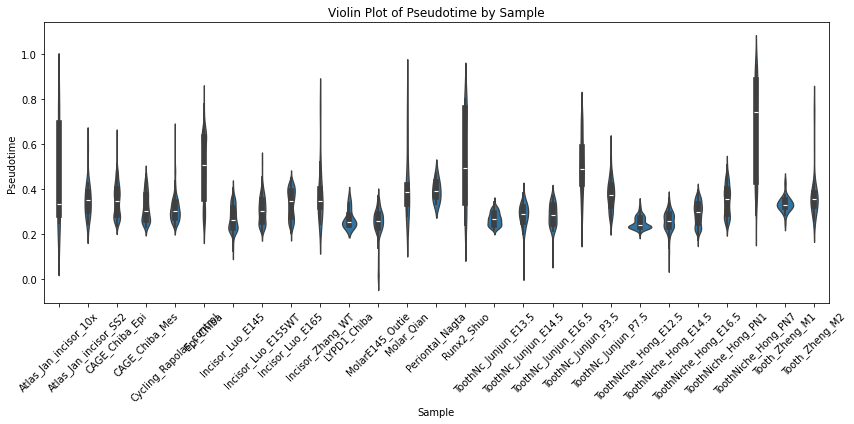

In [10]:
df = adata.obs[["pseudo","Sample"]]
# 2. Violin plot for more detailed distribution
plt.figure(figsize=(12, 6))
sns.violinplot(x="Sample", y="pseudo", data=df)
plt.title("Violin Plot of Pseudotime by Sample")
plt.ylabel("Pseudotime")
plt.xticks(rotation=45)
plt.tight_layout()

In [15]:
adata[:,0:20]

View of AnnData object with n_obs × n_vars = 8000 × 20
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'coarse_anno_1', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'size_factors', 'Sample', 'Project', 'Core_datasets', 'Mandibular_Maxillary', 'Molar_Incisor', 'Tooth.position', 'Histology', 'Sex', 'Gene.Type', 'Knockout_gene', 'Cre', 'Treatment', 'FACs', 'Age', 'Stage', 'Development.stage', 'Disease', 'Strain', 'Dissociation_enzyme', 'Machine', 'Species', 'Related.assay', 'Journal', 'Data.Source', 'Data.location', 'new_totals_log', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scDblFinder_class', 'leiden', 'anno_level_1', 'Cell_ID', 'index', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'leiden_clusters_level_3', 'leiden_clusters_level_

In [3]:

# Convert to 3D matrix
print("\nConverting to 3D matrix using Gaussian kernel interpolation...")
result = anndata_to_3d_matrix(
    adata=adata,
    pseudo_col='pseudo',     # Column containing pseudotime
    batch_col='Sample',      # Column containing batch information
    n_bins=100,              # Number of interpolation points
    adaptive_kernel=True,    # Use adaptive kernel width
    gene_thred=0.1,          # Filter genes expressed in at least 10% of bins
    batch_thred=0.3,         # Filter batches covering at least 30% of timeline
    ensure_tail=True         # Ensure batches cover the tail region
)
reshaped_data = result["reshaped_data"]



Converting to 3D matrix using Gaussian kernel interpolation...
Calculating bin means in parallel...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:    3.1s
[Parallel(n_jobs=36)]: Done 692 out of 692 | elapsed:    5.2s finished
[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.


Filtered to 82 genes that meet expression threshold
Batches after coverage filtering: ['CAGE_Chiba_Epi', 'Epi_Chiba', 'MolarE145_Outie', 'Runx2_Shuo', 'ToothNc_Junjun_P3.5', 'ToothNc_Junjun_P7.5', 'ToothNiche_Hong_PN7']
Contingency table of unique bins in tail region:
Batch CAGE_Chiba_Epi filtered out: 0 tail bins <= 2.0 threshold
Batch Epi_Chiba qualified: 4 tail bins > 2.0 threshold
Batch MolarE145_Outie filtered out: 0 tail bins <= 2.0 threshold
Batch Runx2_Shuo qualified: 10 tail bins > 2.0 threshold
Batch ToothNc_Junjun_P3.5 qualified: 9 tail bins > 2.0 threshold
Batch ToothNc_Junjun_P7.5 filtered out: 0 tail bins <= 2.0 threshold
Batch ToothNiche_Hong_PN7 qualified: 27 tail bins > 2.0 threshold
Final qualified batches: ['Epi_Chiba', 'Runx2_Shuo', 'ToothNc_Junjun_P3.5', 'ToothNiche_Hong_PN7']
Computing Gaussian kernel weights...
Interpolating gene expression for 4 batches and 82 genes using 36 parallel jobs...


/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning:

Interpolation complete. 3D matrix shape: (4, 100, 82)


[Parallel(n_jobs=36)]: Done 328 out of 328 | elapsed:    4.5s finished


In [4]:
reshaped_data.shape

(4, 100, 82)

In [4]:
reshaped_data.shape

(4, 100, 82)

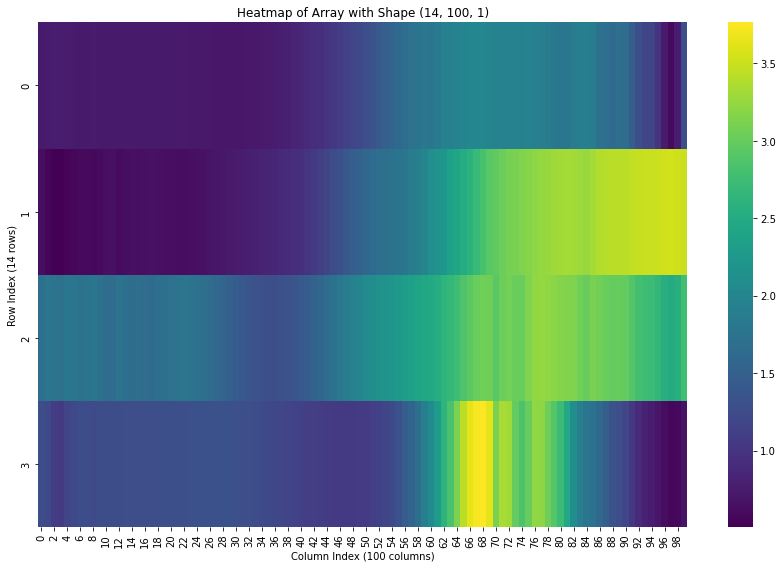

Array shape: (4, 100)
Min value: 0.5063482769902896
Max value: 3.7643455447895944
Mean value: 1.7182119170740418


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create sample data with shape (14, 100, 1)
# You can replace this with your actual data
data = reshaped_data[0:4,0:100,1]

# Reshape the data to 2D since the third dimension is 1
# This will give us a 2D array of shape (14, 100)
data_2d = data.reshape(4, 100)

# Create a figure with a larger size for better visibility
plt.figure(figsize=(12, 8))

# Create the heatmap using seaborn
# 'cmap' determines the color scheme - you can try different options like 'viridis', 'plasma', 'Blues', etc.
sns.heatmap(data_2d, cmap='viridis', cbar=True)

# Add title and labels
plt.title('Heatmap of Array with Shape (14, 100, 1)')
plt.xlabel('Column Index (100 columns)')
plt.ylabel('Row Index (14 rows)')

# Save the figure (optional)


# Show the plot
plt.tight_layout()
plt.show()

# If you want to see specific values in your array, you can print some statistics
print(f"Array shape: {data.shape}")
print(f"Min value: {data.min()}")
print(f"Max value: {data.max()}")
print(f"Mean value: {data.mean()}") 

Calculating bin means in parallel...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=36)]: Done 692 out of 692 | elapsed:    4.4s finished


Filtered to 82 genes that meet expression threshold
Batches after coverage filtering: ['CAGE_Chiba_Epi', 'Epi_Chiba', 'MolarE145_Outie', 'Runx2_Shuo', 'ToothNc_Junjun_P3.5', 'ToothNc_Junjun_P7.5', 'ToothNiche_Hong_PN7']
Contingency table of unique bins in tail region:
Batch CAGE_Chiba_Epi filtered out: 0 tail bins <= 2.0 threshold
Batch Epi_Chiba qualified: 4 tail bins > 2.0 threshold
Batch MolarE145_Outie filtered out: 0 tail bins <= 2.0 threshold
Batch Runx2_Shuo qualified: 10 tail bins > 2.0 threshold
Batch ToothNc_Junjun_P3.5 qualified: 9 tail bins > 2.0 threshold
Batch ToothNc_Junjun_P7.5 filtered out: 0 tail bins <= 2.0 threshold
Batch ToothNiche_Hong_PN7 qualified: 27 tail bins > 2.0 threshold
Final qualified batches: ['Epi_Chiba', 'Runx2_Shuo', 'ToothNc_Junjun_P3.5', 'ToothNiche_Hong_PN7']
Computing Gaussian kernel weights...
Interpolating gene expression for 4 batches and 82 genes using 36 parallel jobs...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anacon

Interpolation complete. 3D matrix shape: (4, 100, 82)


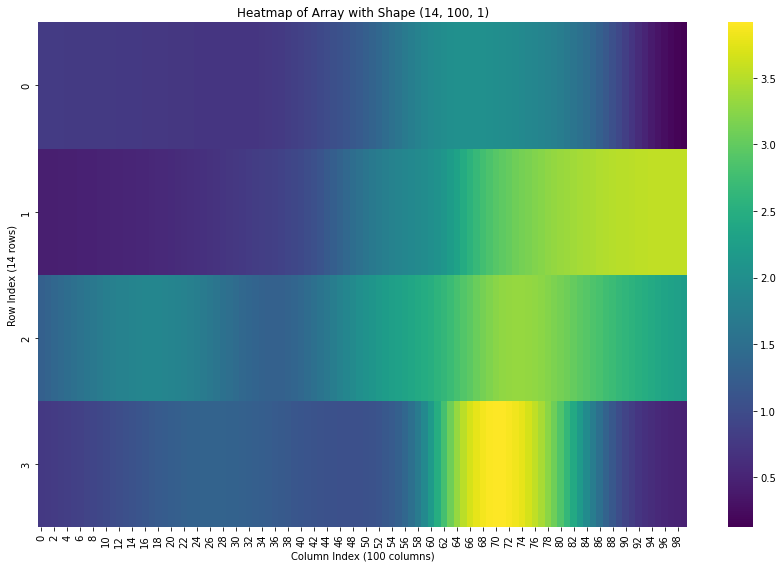

Array shape: (4, 100)
Min value: 0.12713535337774884
Max value: 3.9154913895138486
Mean value: 1.6795250273369362


In [21]:
result2 = anndata_to_3d_matrix(
    adata=adata,
    pseudo_col='pseudo',     # Column containing pseudotime
    batch_col='Sample',      # Column containing batch information
    n_bins=100,              # Number of interpolation points
    adaptive_kernel=False,    # Use adaptive kernel width
    gene_thred=0.1,          # Filter genes expressed in at least 10% of bins
    batch_thred=0.3,         # Filter batches covering at least 30% of timeline
    ensure_tail=True         # Ensure batches cover the tail region
)

reshaped_data2 = result2["reshaped_data"]

# Create sample data with shape (14, 100, 1)
# You can replace this with your actual data
data = reshaped_data2[0:4,0:100,1]

# Reshape the data to 2D since the third dimension is 1
# This will give us a 2D array of shape (14, 100)
data_2d = data.reshape(4, 100)

# Create a figure with a larger size for better visibility
plt.figure(figsize=(12, 8))

# Create the heatmap using seaborn
# 'cmap' determines the color scheme - you can try different options like 'viridis', 'plasma', 'Blues', etc.
sns.heatmap(data_2d, cmap='viridis', cbar=True)

# Add title and labels
plt.title('Heatmap of Array with Shape (14, 100, 1)')
plt.xlabel('Column Index (100 columns)')
plt.ylabel('Row Index (14 rows)')

# Save the figure (optional)


# Show the plot
plt.tight_layout()
plt.show()

# If you want to see specific values in your array, you can print some statistics
print(f"Array shape: {data.shape}")
print(f"Min value: {data.min()}")
print(f"Max value: {data.max()}")
print(f"Mean value: {data.mean()}") 

In [7]:
import traj_dwt
data_3d, meta, gene_names = traj_dwt.anndata_to_3d_matrix(
        adata,
        min_cells_per_bin=0,
        time_col="pseudo",
        batch_thresh=0.3,
        n_timepoints=100,
        batch_col="Sample",
        layer="logcounts",
        tail_width=0.3,
        ensure_tail=True

    )

2025-04-15 11:14:10,858 - traj_dwt.utils - INFO - Found 27 batches in data
2025-04-15 11:14:10,893 - traj_dwt.utils - INFO - Filtered batches based on tail representation: 27 -> 27


/home/gilberthan/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gilberthan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/gilberthan/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gilberthan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/gilberthan/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gilberthan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide

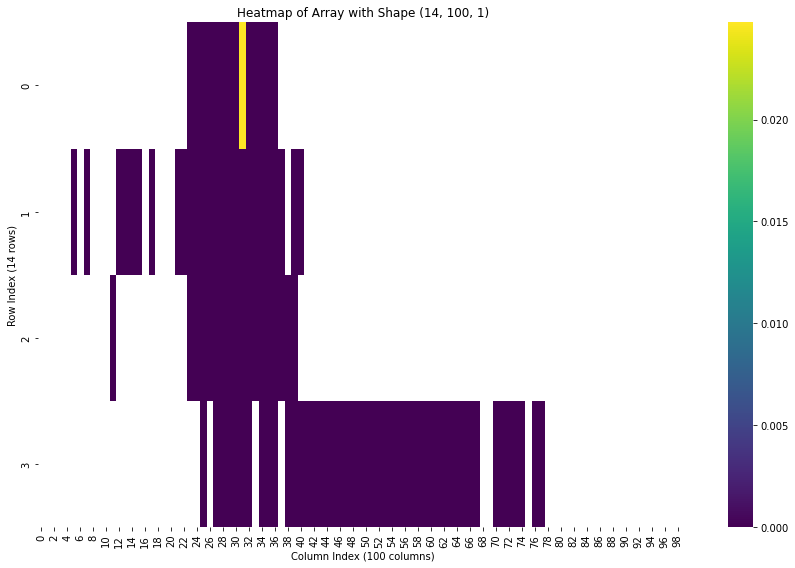

Array shape: (4, 100)
Min value: nan
Max value: nan
Mean value: nan


In [8]:

# Create sample data with shape (14, 100, 1)
# You can replace this with your actual data
data = data_3d[0:4,0:100,1]

# Reshape the data to 2D since the third dimension is 1
# This will give us a 2D array of shape (14, 100)
data_2d = data.reshape(4, 100)

# Create a figure with a larger size for better visibility
plt.figure(figsize=(12, 8))

# Create the heatmap using seaborn
# 'cmap' determines the color scheme - you can try different options like 'viridis', 'plasma', 'Blues', etc.
sns.heatmap(data_2d, cmap='viridis', cbar=True)

# Add title and labels
plt.title('Heatmap of Array with Shape (14, 100, 1)')
plt.xlabel('Column Index (100 columns)')
plt.ylabel('Row Index (14 rows)')

# Save the figure (optional)


# Show the plot
plt.tight_layout()
plt.show()

# If you want to see specific values in your array, you can print some statistics
print(f"Array shape: {data.shape}")
print(f"Min value: {data.min()}")
print(f"Max value: {data.max()}")
print(f"Mean value: {data.mean()}") 

In [16]:
def anndata_to_3d_matrix_simple(adata, pseudo_col, batch_col, n_bins=100, 
                              gene_thred=0.1, batch_thred=0.3, 
                              ensure_tail=True, tail_width=0.3, tail_num=0.02, 
                              verbose=True, n_jobs=-1):
    """
    Convert AnnData object to 3D matrix using simple binning without Gaussian kernel interpolation.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object
    pseudo_col : str
        Column in adata.obs containing pseudotime
    batch_col : str
        Column in adata.obs containing batch information
    n_bins : int
        Number of bins along pseudotime
    gene_thred : float
        Threshold for gene filtering (fraction of bins where gene is expressed)
    batch_thred : float
        Threshold for batch filtering (fraction of bins covered)
    ensure_tail : bool
        Whether to ensure batches cover the tail region
    tail_width : float
        Width of the tail region (fraction of bins)
    tail_num : float
        Minimum fraction of tail bins that must be covered
    verbose : bool
        Whether to print progress information
    n_jobs : int, optional
        Number of parallel jobs to run. -1 means using all processors.
        
    Returns
    -------
    dict
        Dictionary containing:
        - reshaped_data: 3D array (batch x time x gene)
        - binned_means: Matrix of binned means
        - filtered_genes: List of genes that passed filtering
        - batch_names: List of batches that passed filtering
        - metadata: DataFrame with metadata
    """
    import numpy as np
    import pandas as pd
    import scipy.sparse
    import joblib
    from joblib import Parallel, delayed
    
    # Extract data
    if scipy.sparse.issparse(adata.X):
        expression_matrix = adata.X.T.tocsr()  # genes x cells
    else:
        expression_matrix = adata.X.T  # genes x cells
        
    pseudotime = np.array(adata.obs[pseudo_col])
    batch_labels = np.array(adata.obs[batch_col])
    
    # Create bins based on pseudotime
    bins = np.linspace(np.min(pseudotime), np.max(pseudotime), n_bins + 1)
    binned_pseudotime = np.digitize(pseudotime, bins) - 1
    binned_pseudotime = np.clip(binned_pseudotime, 0, n_bins - 1) + 1  # 1-based indexing
    
    # Create metadata with binned pseudotime
    metadata = pd.DataFrame({
        'batch': batch_labels,
        'pseudotime_binned': binned_pseudotime
    })
    metadata['bin'] = metadata['batch'] + "_" + metadata['pseudotime_binned'].astype(str)
    
    # Calculate bin means using traditional binning
    unique_bins = metadata['bin'].unique()
    bin_to_idx = {bin_name: idx for idx, bin_name in enumerate(unique_bins)}
    cell_bin_indices = np.array([bin_to_idx[bin_name] for bin_name in metadata['bin']])
    
    # Define the helper function for parallel bin mean calculation
    def _process_bin(bin_idx):
        bin_mask = cell_bin_indices == bin_idx
        if np.sum(bin_mask) > 0:
            if scipy.sparse.issparse(expression_matrix):
                bin_expr = expression_matrix[:, bin_mask].toarray()
            else:
                bin_expr = expression_matrix[:, bin_mask]
            return np.mean(bin_expr, axis=1)
        return np.zeros(expression_matrix.shape[0])
    
    # Calculate bin means in parallel
    if verbose:
        print("Calculating bin means in parallel...")
        
    # Use joblib for parallel bin mean calculation
    n_jobs = n_jobs if n_jobs > 0 else joblib.cpu_count()
    actual_n_jobs = min(n_jobs, len(unique_bins))
    
    binned_means = np.zeros((expression_matrix.shape[0], len(unique_bins)))
    
    # Use joblib parallelization for bin mean calculation
    bin_means_results = Parallel(n_jobs=actual_n_jobs, verbose=1 if verbose else 0)(
        delayed(_process_bin)(bin_idx) for bin_idx in range(len(unique_bins))
    )
    
    # Convert results to array
    for bin_idx, bin_mean in enumerate(bin_means_results):
        binned_means[:, bin_idx] = bin_mean
    
    # Filter genes
    gene_expressed = (binned_means > 0).sum(axis=1)
    gene_threshold = gene_thred * binned_means.shape[1]
    filtered_gene_indices = np.where(gene_expressed > gene_threshold)[0]
    filtered_genes = np.array(adata.var_names)[filtered_gene_indices]
    
    if verbose:
        print(f"Filtered to {len(filtered_genes)} genes that meet expression threshold")
    
    # Filter batches
    # This is a simplified version of the filter_batches_by_coverage function
    unique_batches = np.unique(batch_labels)
    qualified_batches = []
    
    # Filter by coverage
    for batch in unique_batches:
        batch_mask = batch_labels == batch
        batch_bins = binned_pseudotime[batch_mask]
        unique_bins = np.unique(batch_bins)
        coverage = len(unique_bins) / n_bins
        
        # Check if batch meets coverage criteria
        if coverage > batch_thred:
            # Check tail coverage if needed
            if ensure_tail:
                tail_threshold = (1 - tail_width) * n_bins
                tail_bins = unique_bins[unique_bins > tail_threshold]
                if len(tail_bins) > tail_num * n_bins:
                    qualified_batches.append(batch)
            else:
                qualified_batches.append(batch)
    
    if verbose:
        print(f"Selected {len(qualified_batches)} batches that meet coverage criteria")
    
    # Create 3D matrix - directly using bin means (no kernel interpolation)
    # Initialize result matrix of shape (batch, time, gene)
    result_3d = np.zeros((len(qualified_batches), n_bins, len(filtered_genes)))
    
    # For each batch and bin, find the matching cells and calculate mean
    for batch_idx, batch in enumerate(qualified_batches):
        if verbose and batch_idx % max(1, len(qualified_batches)//10) == 0:
            print(f"Processing batch {batch_idx+1}/{len(qualified_batches)}: {batch}")
            
        for bin_idx in range(1, n_bins+1):
            # Get cells that belong to this batch and bin
            mask = (batch_labels == batch) & (binned_pseudotime == bin_idx)
            
            if np.any(mask):
                # If cells exist for this batch-bin combination
                cell_indices = np.where(mask)[0]
                
                # Get expression values for filtered genes
                if scipy.sparse.issparse(expression_matrix):
                    bin_expr = expression_matrix[filtered_gene_indices, :][:, cell_indices].toarray()
                else:
                    bin_expr = expression_matrix[filtered_gene_indices, :][:, cell_indices]
                
                # Calculate mean and store in result (transpose to get genes as last dimension)
                bin_means = np.mean(bin_expr, axis=1)
                result_3d[batch_idx, bin_idx-1, :] = bin_means
    
    if verbose:
        print(f"Created 3D matrix with shape: {result_3d.shape}")
    
    # Return results
    return {
        'reshaped_data': result_3d,
        'binned_means': pd.DataFrame(binned_means, index=adata.var_names),
        'filtered_genes': filtered_genes,
        'batch_names': qualified_batches,
        'metadata': metadata
    }

In [17]:
res_test = anndata_to_3d_matrix_simple(
    adata=adata,
    pseudo_col='pseudo',     # Column containing pseudotime
    batch_col='Sample',      # Column containing batch information
    n_bins=100,              # Number of interpolation points
)


Calculating bin means in parallel...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 129 tasks      | elapsed:    3.6s
[Parallel(n_jobs=36)]: Done 379 tasks      | elapsed:    6.2s
[Parallel(n_jobs=36)]: Done 692 out of 692 | elapsed:    9.5s finished


Filtered to 82 genes that meet expression threshold
Selected 4 batches that meet coverage criteria
Processing batch 1/4: Epi_Chiba
Processing batch 2/4: Runx2_Shuo
Processing batch 3/4: ToothNc_Junjun_P3.5
Processing batch 4/4: ToothNiche_Hong_PN7
Created 3D matrix with shape: (4, 100, 82)


In [19]:
res_test['reshaped_data'].shape

(4, 100, 82)

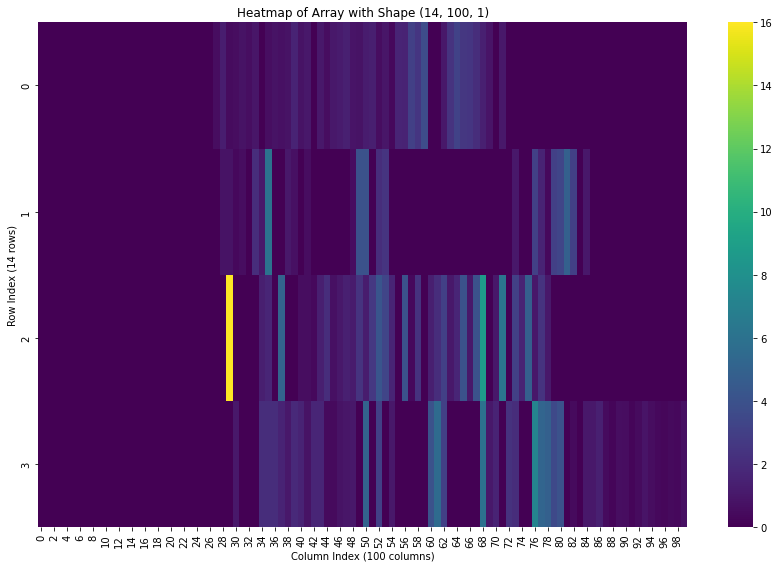

Array shape: (4, 100)
Min value: 0.0
Max value: 16.0
Mean value: 0.7238304777027698


In [20]:

# Create sample data with shape (14, 100, 1)
# You can replace this with your actual data
data = res_test['reshaped_data'][0:4,0:100,1]

# Reshape the data to 2D since the third dimension is 1
# This will give us a 2D array of shape (14, 100)
data_2d = data.reshape(4, 100)

# Create a figure with a larger size for better visibility
plt.figure(figsize=(12, 8))

# Create the heatmap using seaborn
# 'cmap' determines the color scheme - you can try different options like 'viridis', 'plasma', 'Blues', etc.
sns.heatmap(data_2d, cmap='viridis', cbar=True)

# Add title and labels
plt.title('Heatmap of Array with Shape (14, 100, 1)')
plt.xlabel('Column Index (100 columns)')
plt.ylabel('Row Index (14 rows)')

# Save the figure (optional)


# Show the plot
plt.tight_layout()
plt.show()

# If you want to see specific values in your array, you can print some statistics
print(f"Array shape: {data.shape}")
print(f"Min value: {data.min()}")
print(f"Max value: {data.max()}")
print(f"Mean value: {data.mean()}") 

In [9]:

# Extract results




Reshaping complete. 3D matrix shape: (4, 100, 82)
Number of batches: 4
Number of genes: 82
Number of timepoints: 100



Reshaping complete. 3D matrix shape: (4, 100, 82)
Number of batches: 4
Number of genes: 82
Number of timepoints: 100
Calculating pairwise DTW distances for 82 genes across 4 samples (6 pairwise comparisons per gene)...
Using normalization method: zscore
Filtering samples by variation: threshold=0.1, metric=max
Processing 82 genes using 36 parallel jobs...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done  82 out of  82 | elapsed:    0.3s finished


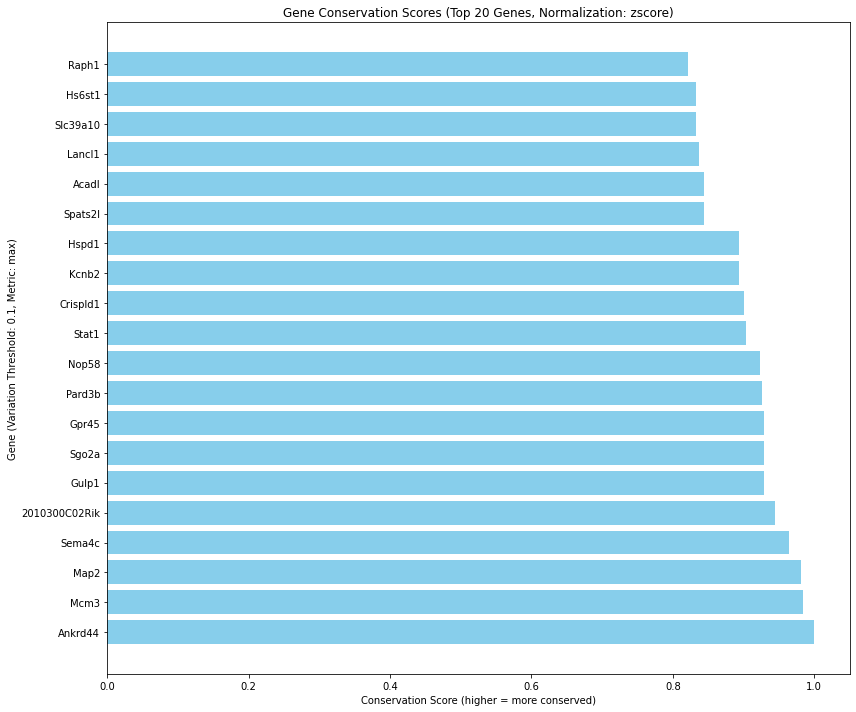

In [6]:

reshaped_data = result['reshaped_data']  # 3D array (batch x time x gene)
filtered_genes = result['filtered_genes']
batch_names = result['batch_names']

print(f"\nReshaping complete. 3D matrix shape: {reshaped_data.shape}")
print(f"Number of batches: {len(batch_names)}")
print(f"Number of genes: {len(filtered_genes)}")
print(f"Number of timepoints: {reshaped_data.shape[1]}")
# Define sample variation filtering parameters
VARIATION_FILTERING = {
    'off': {
        'filter_samples_by_variation': False
    },
    'basic': {
        'filter_samples_by_variation': True,
        'variation_threshold': 0.1,  # Minimum coefficient of variation
        'variation_metric': 'max',
        'min_valid_samples': 2       # At least 2 samples needed
    },
    'stringent': {
        'filter_samples_by_variation': True,
        'variation_threshold': 0.2, 
        'variation_metric': 'max',
        'min_valid_samples': 2
    }
}

# Choose filtering level
variation_filter_level = 'basic'  # Options: 'off', 'basic', 'stringent'
filter_params = VARIATION_FILTERING[variation_filter_level]

conservation_results = calculate_trajectory_conservation(
    trajectory_data=reshaped_data,
    gene_names=filtered_genes, 
    save_dir=output_dir,
    prefix="traj_conservation",
    dtw_radius=3,            # Radius parameter for fastdtw
    use_fastdtw=True,
    normalize='zscore',      # Normalize trajectories before DTW calculation
    **filter_params          # Apply sample variation filtering
)


In [35]:
conservation_results.keys()

dict_keys(['pairwise_distances', 'conservation_scores', 'similarity_matrix', 'conserved_samples', 'metadata', 'filtering_info'])

In [24]:
conservation_results["pairwise_distances"]

{'Xkr4':           Sample_0  Sample_1   Sample_2   Sample_3
 Sample_0       0.0       0.0   0.000000   0.000000
 Sample_1       0.0       0.0   0.000000   0.000000
 Sample_2       0.0       0.0   0.000000  46.103029
 Sample_3       0.0       0.0  46.103029   0.000000,
 'Sgk3':            Sample_0   Sample_1   Sample_2   Sample_3
 Sample_0   0.000000  24.377599  19.119751  30.115461
 Sample_1  24.377599   0.000000  21.354678  64.998138
 Sample_2  19.119751  21.354678   0.000000  48.708878
 Sample_3  30.115461  64.998138  48.708878   0.000000,
 'Sulf1':            Sample_0    Sample_1    Sample_2    Sample_3
 Sample_0   0.000000   57.140252   92.838069   77.109243
 Sample_1  57.140252    0.000000  129.585788  127.258364
 Sample_2  92.838069  129.585788    0.000000   17.341331
 Sample_3  77.109243  127.258364   17.341331    0.000000,
 'Ncoa2':            Sample_0   Sample_1   Sample_2   Sample_3
 Sample_0   0.000000  85.970938  80.835636  54.140637
 Sample_1  85.970938   0.000000  90.5183

View of AnnData object with n_obs × n_vars = 1000 × 100
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'coarse_anno_1', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'size_factors', 'Sample', 'Project', 'Core_datasets', 'Mandibular_Maxillary', 'Molar_Incisor', 'Tooth.position', 'Histology', 'Sex', 'Gene.Type', 'Knockout_gene', 'Cre', 'Treatment', 'FACs', 'Age', 'Stage', 'Development.stage', 'Disease', 'Strain', 'Dissociation_enzyme', 'Machine', 'Species', 'Related.assay', 'Journal', 'Data.Source', 'Data.location', 'new_totals_log', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scDblFinder_class', 'leiden', 'anno_level_1', 'Cell_ID', 'index', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'leiden_clusters_level_3', 'leiden_clusters_level

In [25]:
# First, create an empty list to store our data
rows = []
# Loop through each gene and its distance matrix
for gene, distance_matrix in conservation_results["pairwise_distances"].items():
    # Convert the distance matrix to a DataFrame if it's not already
    if not isinstance(distance_matrix, pd.DataFrame):
        distance_matrix = pd.DataFrame(distance_matrix)
    
    # Get the upper triangular part of the matrix (excluding diagonal)
    # since distance matrices are symmetric
    mask = np.triu(np.ones(distance_matrix.shape), k=1).astype(bool)
    
    # Extract the sample pairs and their distances
    for i, row_idx in enumerate(distance_matrix.index):
        for j, col_idx in enumerate(distance_matrix.columns):
            if j > i:  # Only upper triangular
                sample1 = row_idx
                sample2 = col_idx
                distance = distance_matrix.iloc[i, j]
                
                # Add this pair to our list
                rows.append({
                    'gene': gene,
                    'sample1': sample1,
                    'sample2': sample2,
                    'distance': distance
                })

# Create a DataFrame from the list
distance_df = pd.DataFrame(rows)

In [26]:
distance_df

,gene,sample1,sample2,distance
0,Xkr4,Sample_0,Sample_1,0.000000
1,Xkr4,Sample_0,Sample_2,0.000000
2,Xkr4,Sample_0,Sample_3,0.000000
3,Xkr4,Sample_1,Sample_2,0.000000
4,Xkr4,Sample_1,Sample_3,0.000000
...,...,...,...,...
313,Lancl1,Sample_0,Sample_2,17.137110
314,Lancl1,Sample_0,Sample_3,59.201490
315,Lancl1,Sample_1,Sample_2,21.396001
316,Lancl1,Sample_1,Sample_3,12.000912


In [54]:
reshaped_data.shape[1]

100

In [20]:
selected_genes = np.array(conservation_results["conservation_scores"]["gene"].head())

In [19]:
filtered_genes

array(['Xkr4', 'Sgk3', 'A830018L16Rik', 'Sulf1', 'Slco5a1', 'Ncoa2',
       'Eya1', 'Kcnb2', 'Sbspon', 'Rdh10', 'Ly96', 'Jph1', 'Pi15',
       'Crispld1', 'Tfap2b', 'Mcm3', 'Gsta3', 'Kcnq5', 'Rims1', 'Khdrbs2',
       'Bag2', 'Dst', 'Ptpn18', 'Arhgef4', 'Hs6st1', 'Arid5a', 'Cnnm4',
       'Sema4c', 'Fam178b', 'Tmem131', 'Mgat4a', '2010300C02Rik', 'Aff3',
       'Lonrf2', 'Chst10', 'Tbc1d8', 'Il1r1', 'Il1rl2', 'Mfsd9', 'Gpr45',
       'Fhl2', 'Gm8251', 'Gulp1', 'Col3a1', 'Col5a2', 'Slc40a1', 'Dnah7b',
       'Slc39a10', 'Cavin2', 'Nabp1', 'Myo1b', 'Stat1', 'Gls', 'Mfsd6',
       '1700019D03Rik', 'Stk17b', 'Hecw2', 'Pgap1', 'Ankrd44', 'Hspd1',
       'Rftn2', 'Plcl1', 'Satb2', 'Spats2l', 'Sgo2a', 'Aox3', 'Aox4',
       'Fzd7', 'Nop58', 'Nbeal1', 'Raph1', 'Pard3b', 'Nrp2', 'Ino80dos',
       'Zdbf2', 'Adam23', 'Klf7', 'Fzd5', 'Map2', 'Kansl1l', 'Acadl',
       'Lancl1'], dtype=object)

In [22]:
time_points = np.linspace(0, 1, reshaped_data.shape[1])
fit_res = fit_with_conserved_samples(
    reshaped_data = reshaped_data, gene_names = selected_genes, 
    conserved_samples = conservation_results["conserved_samples"], time_points = time_points, interpolation_factor=1,
    top_n_genes=10, n_jobs=4, verbose=True, spline_smoothing=2
)

Creating specialized datasets for each gene:
  Gene Ankrd44: Using 2 most conserved samples out of 4 total
  Gene Mcm3: Using 2 most conserved samples out of 4 total
  Gene Map2: Using 2 most conserved samples out of 4 total
  Gene Sema4c: Using 2 most conserved samples out of 4 total
  Gene 2010300C02Rik: Using 2 most conserved samples out of 4 total
Initializing TrajectoryFitter...

Processing each gene with its most conserved samples...

Processing gene 1/5: Ankrd44
  Fitting standard spline model...
Fitting spline model to data with shape (2, 100, 1)
Fitting spline with degree 3 and smoothing 2
Fitted feature 1/1, DTW distance: 64.1187
Fitting completed in 0.07 seconds
Model score: -64.1187
  Fitting DTW-optimized spline model...
Fitting spline model to data with shape (2, 100, 1)
Fitting spline with degree 3 and optimizing smoothing to minimize DTW distance
Fitted feature 1/1, optimal smoothing: 0.0100, DTW distance: 60.9836
Fitting completed in 0.39 seconds
Model score: -60.9836


In [37]:
fit_res.keys()

dict_keys(['standard_results', 'optimized_results', 'top_gene_names', 'top_genes_data'])

In [50]:
fit_res["standard_results"].keys()

dict_keys(['fitted_params', 'fitted_trajectories', 'dtw_distances', 'smoothing_values', 'time_points', 'model_score', 'mean_dtw_distance'])

In [58]:
fit_res["standard_results"]["time_points"]

array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
       0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
       0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
       0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
       0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
       0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
       0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
       0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
       0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
       0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
       0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
       0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
       0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
       0.35175879, 0.35678392, 0.36180905, 0.36683417, 0.37185

In [60]:
fit_res["standard_results"]["fitted_trajectories"].shape

(100, 10)

<Axes: >

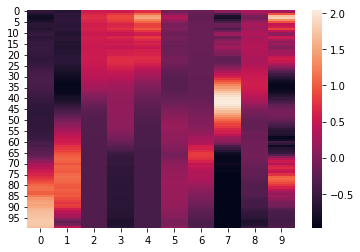

In [62]:
sns.heatmap(fit_res["standard_results"]["fitted_trajectories"])

<Axes: >

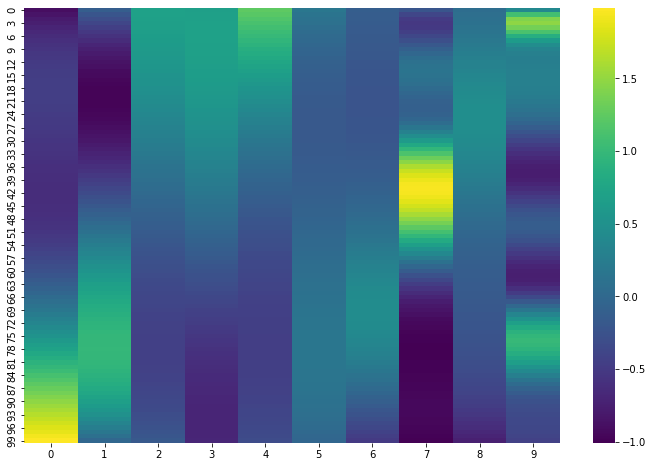

In [65]:
# Create a figure with a larger size for better visibility
plt.figure(figsize=(12, 8))

# Create the heatmap using seaborn
# 'cmap' determines the color scheme - you can try different options like 'viridis', 'plasma', 'Blues', etc.
sns.heatmap(fit_res["optimized_results"]["fitted_trajectories"], cmap='viridis', cbar=True)


<Axes: >

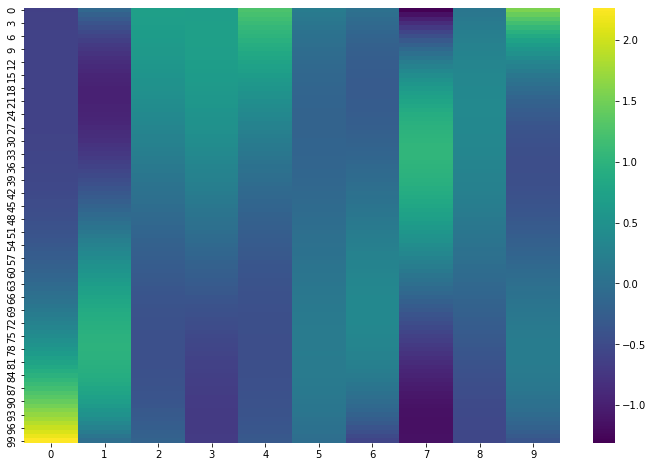

In [69]:
# Create a figure with a larger size for better visibility
plt.figure(figsize=(12, 8))

# Create the heatmap using seaborn
# 'cmap' determines the color scheme - you can try different options like 'viridis', 'plasma', 'Blues', etc.
sns.heatmap(fit_res["standard_results"]["fitted_trajectories"], cmap='viridis', cbar=True)


In [ ]:
fitdf = pd.DataFrame(fit_res["standard_results"]["fitted_trajectories"])
fitdf.index = selected_genes
fitdf.columns = result["batch_names"]


In [31]:
fitdf

,0,1,2,3,4
0,-0.329424,0.075273,0.0,1.147977,1.626991
1,-0.298608,-0.045853,0.0,1.139722,1.560550
2,-0.270029,-0.158912,0.0,1.130336,1.495400
3,-0.243625,-0.264083,0.0,1.119849,1.431530
4,-0.219335,-0.361549,0.0,1.108288,1.368930
...,...,...,...,...,...
95,1.156743,-0.561014,0.0,-0.842050,-0.423624
96,1.250751,-0.727095,0.0,-0.833811,-0.415918
97,1.348389,-0.902372,0.0,-0.824066,-0.407953
98,1.449718,-1.087027,0.0,-0.812790,-0.399741


In [ ]:
fitdf.to_csv("fitted_trajectories.csv")